# Classification Test 2

### 20140678 조정효

- S&P500의 505개 주식 중, 2016년 부터 데이터를 얻을 수 있었던 482개 주식의 수익률을 가지고 Hyatt Hotel의 주가 수익률의 방향을 예측해보는 실험을 해보았다.
- 연구의 목적: Classification model 비교
- PCA-SVM, Random Forest, Gaussian Naive Bayesian, Decision Tree, Adaboost, Gradient Boost


In [9]:
import numpy as np
import pandas as pd
import fix_yahoo_finance as yf
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

## Data

In [3]:
a = pd.read_csv('C:data.csv')

In [4]:
a = a.set_index(pd.to_datetime(a['Date']), drop=True)
a= a.drop('Date', axis=1)
data = a

In [5]:


ret = data.pct_change().iloc[2:]
ret = ret.dropna(axis=1)
ret.shape

(862, 482)

In [10]:
# y data
h = yf.download('H',start='2016-01-03',end='2019-06-09')
h = h[['Adj Close']]
retl = h.pct_change().dropna()

[*********************100%***********************]  1 of 1 downloaded


In [11]:
target = pd.DataFrame({'Hyatt':np.where(retl['Adj Close'] >= 0, 1, -1)}, index = retl.index)
target.head()
target.shape

(862, 1)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(ret, target, random_state=33)

## PCA-SVM Pipeline

In [13]:
from sklearn.decomposition import PCA 

In [14]:
pca = PCA().fit(ret)

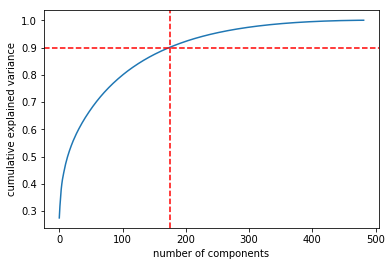

In [15]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axhline(0.90, c='r', ls='--' )
plt.axvline(175, c='r', ls='--' )

In [16]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

In [17]:
pca = PCA(n_components=175, whiten=True, random_state=33)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

In [18]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
               'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)
y_train_ravel = y_train.values.ravel()

%time grid.fit(X_train, y_train_ravel)
print(grid.best_params_)

C:\Users\Cho\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Wall time: 37.6 s
{'svc__C': 50, 'svc__gamma': 0.0001}


In [19]:
model = grid.best_estimator_
print(model)
yfit_ps = model.predict(X_test)

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=175, random_state=33,
  svd_solver='auto', tol=0.0, whiten=True)), ('svc', SVC(C=50, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])


## PCA-SVM Result

In [20]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, yfit_ps)

0.6574074074074074

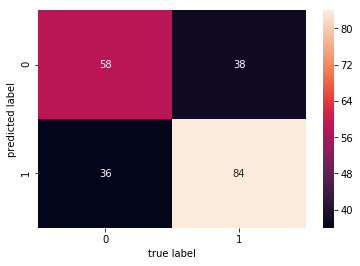

In [55]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, yfit_ps)
sns.heatmap(mat , annot=True)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [58]:
from sklearn.metrics import classification_report

In [60]:
print(classification_report(y_test, yfit_ps))

              precision    recall  f1-score   support

          -1       0.62      0.60      0.61        96
           1       0.69      0.70      0.69       120

   micro avg       0.66      0.66      0.66       216
   macro avg       0.65      0.65      0.65       216
weighted avg       0.66      0.66      0.66       216



## Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train )

C:\Users\Cho\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Cho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [25]:
param_grid2 = {'max_depth':[2,3,4,5,6,7]}
grid2 = GridSearchCV(clf_rf, param_grid2)
rf_best = grid.best_estimator_
yfit_rf_best = rf_best.predict(X_test)

## Random Forest Result

In [26]:
from sklearn.metrics import accuracy_score
yfit_rf = clf_rf.predict(X_test)
accuracy_score(y_test, yfit_rf)

0.7083333333333334

In [27]:
#Gridsearch
accuracy_score(y_test, yfit_rf_best)
#ban

0.6574074074074074

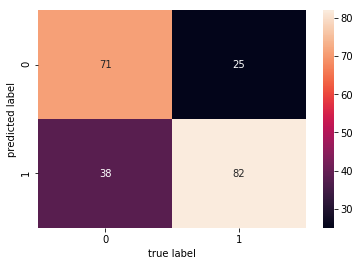

In [53]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, yfit_rf)
sns.heatmap(mat , annot=True)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [61]:
print(classification_report(y_test, yfit_rf))

              precision    recall  f1-score   support

          -1       0.65      0.74      0.69        96
           1       0.77      0.68      0.72       120

   micro avg       0.71      0.71      0.71       216
   macro avg       0.71      0.71      0.71       216
weighted avg       0.72      0.71      0.71       216



## Gaussian Naive Bayesian & Result

In [29]:
from sklearn.naive_bayes import GaussianNB
modelgnb = GaussianNB()
modelgnb.fit(X_train, y_train);
yfit_gnb = modelgnb.predict(X_test)

C:\Users\Cho\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [30]:

accuracy_score(y_test, yfit_gnb)

0.6944444444444444

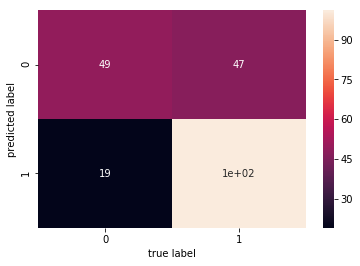

In [51]:
mat = confusion_matrix(y_test, yfit_gnb)
sns.heatmap(mat , annot=True)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [62]:
print(classification_report(y_test, yfit_gnb))

              precision    recall  f1-score   support

          -1       0.72      0.51      0.60        96
           1       0.68      0.84      0.75       120

   micro avg       0.69      0.69      0.69       216
   macro avg       0.70      0.68      0.68       216
weighted avg       0.70      0.69      0.68       216



## Boosting

### Ada-boosting

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(),n_estimators=50,  learning_rate=0.1)
abc.fit(X_train, y_train)
yfit_abc = abc.predict(X_test)

C:\Users\Cho\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [33]:

accuracy_score(y_test, yfit_abc)


0.7175925925925926

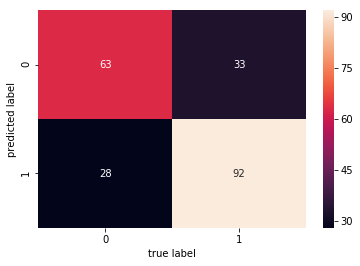

In [49]:
mat = confusion_matrix(y_test, yfit_abc)
sns.heatmap(mat , annot=True)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [63]:
print(classification_report(y_test, yfit_abc))

              precision    recall  f1-score   support

          -1       0.69      0.66      0.67        96
           1       0.74      0.77      0.75       120

   micro avg       0.72      0.72      0.72       216
   macro avg       0.71      0.71      0.71       216
weighted avg       0.72      0.72      0.72       216



### Gradient Boosting (the best so far..

In [35]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier( n_estimators=120, max_depth=2)
gbc.fit(X_train, y_train)
yfit_gbc = gbc.predict(X_test)

accuracy_score(y_test, yfit_gbc)

C:\Users\Cho\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7407407407407407

In [36]:
from sklearn.metrics import mean_squared_error
err = [mean_squared_error(y_test, yhat) for yhat in gbc.staged_predict(X_test)]
idx = np.argmin(err)
idx

8

In [37]:
gbc_best = GradientBoostingClassifier( n_estimators=8, max_depth=2)
gbc_best.fit(X_train, y_train)
yfit_gbc_best = gbc_best.predict(X_test)

C:\Users\Cho\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [38]:
#best hyperparameter
accuracy_score(y_test, yfit_gbc_best)


0.7824074074074074

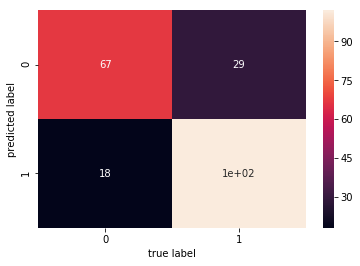

In [39]:
mat = confusion_matrix(y_test, yfit_gbc_best)
sns.heatmap(mat , annot=True)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [64]:
print(classification_report(y_test, yfit_gbc_best))

              precision    recall  f1-score   support

          -1       0.79      0.70      0.74        96
           1       0.78      0.85      0.81       120

   micro avg       0.78      0.78      0.78       216
   macro avg       0.78      0.77      0.78       216
weighted avg       0.78      0.78      0.78       216



## Tree Model (single)

In [40]:
params = {'max_depth': [2,3,4,5,6]}
dtc_grid = GridSearchCV(DecisionTreeClassifier(), params, cv=5)
dtc_grid

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [2, 3, 4, 5, 6]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [41]:
dtc_grid.fit(X_train, y_train)
dtc_grid.best_estimator_

C:\Users\Cho\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [42]:
yfit_dtc_best = dtc_grid.best_estimator_.predict(X_test)
accuracy_score(yfit_dtc_best, y_test)
#not bad at all

0.7685185185185185

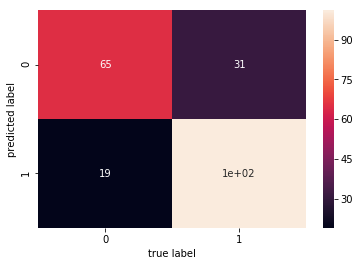

In [43]:
mat = confusion_matrix(y_test, yfit_dtc_best)
sns.heatmap(mat , annot=True)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [65]:
print(classification_report(y_test, yfit_dtc_best))

              precision    recall  f1-score   support

          -1       0.77      0.68      0.72        96
           1       0.77      0.84      0.80       120

   micro avg       0.77      0.77      0.77       216
   macro avg       0.77      0.76      0.76       216
weighted avg       0.77      0.77      0.77       216



## XGBoost

# 부록 ( classification report) 
### from https://muthu.co/understanding-the-classification-report-in-sklearn/

what is that?

### Precision: What percent of your predictions were correct?

Precision is the ability of a classifier not to label an instance positive that is actually negative. For each class it is defined as the ratio of true positives to the sum of true and false positives.

- TP – True Positives
- FP – False Positives

* Precision – Accuracy of positive predictions.
* Precision = TP/(TP + FP)

### Recall: What percent of the positive cases did you catch? 

Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives.

- FN – False Negatives

- Recall: Fraction of positives that were correctly identified.
- Recall = TP/(TP+FN)

### F1 score: What percent of positive predictions were correct? 

The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. Generally speaking, F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.

- F1 Score = 2$*$(Recall $*$ Precision) / (Recall + Precision)

# 결론 (Classification Model Evaluation)

Classification report의 +,-에 대한 precision, recall, F1 score의 가중 평균을 살펴본 결과

- Gradient Boost (78,78,78)
- Decision Tree (77,77,77)
- Adaboost (72,72,72)
- Random Forest (72,71,71)
- Gaussian Naive Bayesian (70,69,68)
- PCA-SVM (66,66,66)

순으로 score가 높게 나왔습니다.